In [653]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [654]:
df_train=pd.read_csv("training.csv",index_col="id")
df_train.sample(10)

,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
id,,,,,,,,,,,,
1152,58,1012.4,20.1,18.6,17.1,15.6,92.0,87.0,0.3,50.0,22.4,1
965,236,1008.4,33.3,30.1,27.0,22.5,84.0,48.0,7.9,60.0,17.2,0
527,163,1006.8,35.4,31.0,27.0,26.4,78.0,53.0,7.8,230.0,14.3,1
2007,183,1008.4,32.0,30.0,28.2,26.4,77.0,78.0,6.5,230.0,28.0,1
131,132,1012.4,31.3,28.8,26.1,22.7,81.0,87.0,2.1,20.0,19.2,1
1775,316,1018.0,21.5,20.9,19.3,19.3,91.0,84.0,1.1,70.0,33.4,1
2051,227,1012.5,27.8,25.9,24.5,23.8,89.0,81.0,2.2,80.0,19.8,1
512,148,1008.9,29.6,27.2,25.8,25.4,70.0,78.0,4.1,250.0,9.1,1
633,269,1014.6,26.3,24.8,23.4,19.9,76.0,20.0,10.1,70.0,26.5,1


In [655]:
df_train["temp_mean"] = df_train[["maxtemp", "temparature", "mintemp"]].mean(axis=1)
df_train['humidity_cloud_interaction'] = df_train['humidity'] * df_train['cloud']
df_train['humidity_sunshine_interaction'] = df_train['humidity'] * df_train['sunshine']
df_train['cloud_sunshine_ratio'] = df_train['cloud'] / (df_train['sunshine'] + 1e-5)
df_train['relative_dryness'] = 100 - df_train['humidity']
df_train['sunshine_percentage'] = df_train['sunshine'] / (df_train['sunshine'] + df_train['cloud'] + 1e-5)
df_train['weather_index'] = (0.4 * df_train['humidity']) + (0.3 * df_train['cloud']) - (0.3 * df_train['sunshine'])

In [656]:
df_train.shape

(2190, 19)

In [657]:
# df_train["rainfall"].replace({"yes":1,"no":0}, inplace=True)
# df_train["rainfall"] = df_train["rainfall"].astype(int)

In [658]:
df_train["rainfall"].value_counts()

rainfall
1    1650
0     540
Name: count, dtype: int64

In [659]:
df_train.isnull().sum()

day                              0
pressure                         0
maxtemp                          0
temparature                      0
mintemp                          0
dewpoint                         0
humidity                         0
cloud                            0
sunshine                         0
winddirection                    0
windspeed                        0
rainfall                         0
temp_mean                        0
humidity_cloud_interaction       0
humidity_sunshine_interaction    0
cloud_sunshine_ratio             0
relative_dryness                 0
sunshine_percentage              0
weather_index                    0
dtype: int64

In [660]:
df_train.duplicated().any()

np.False_

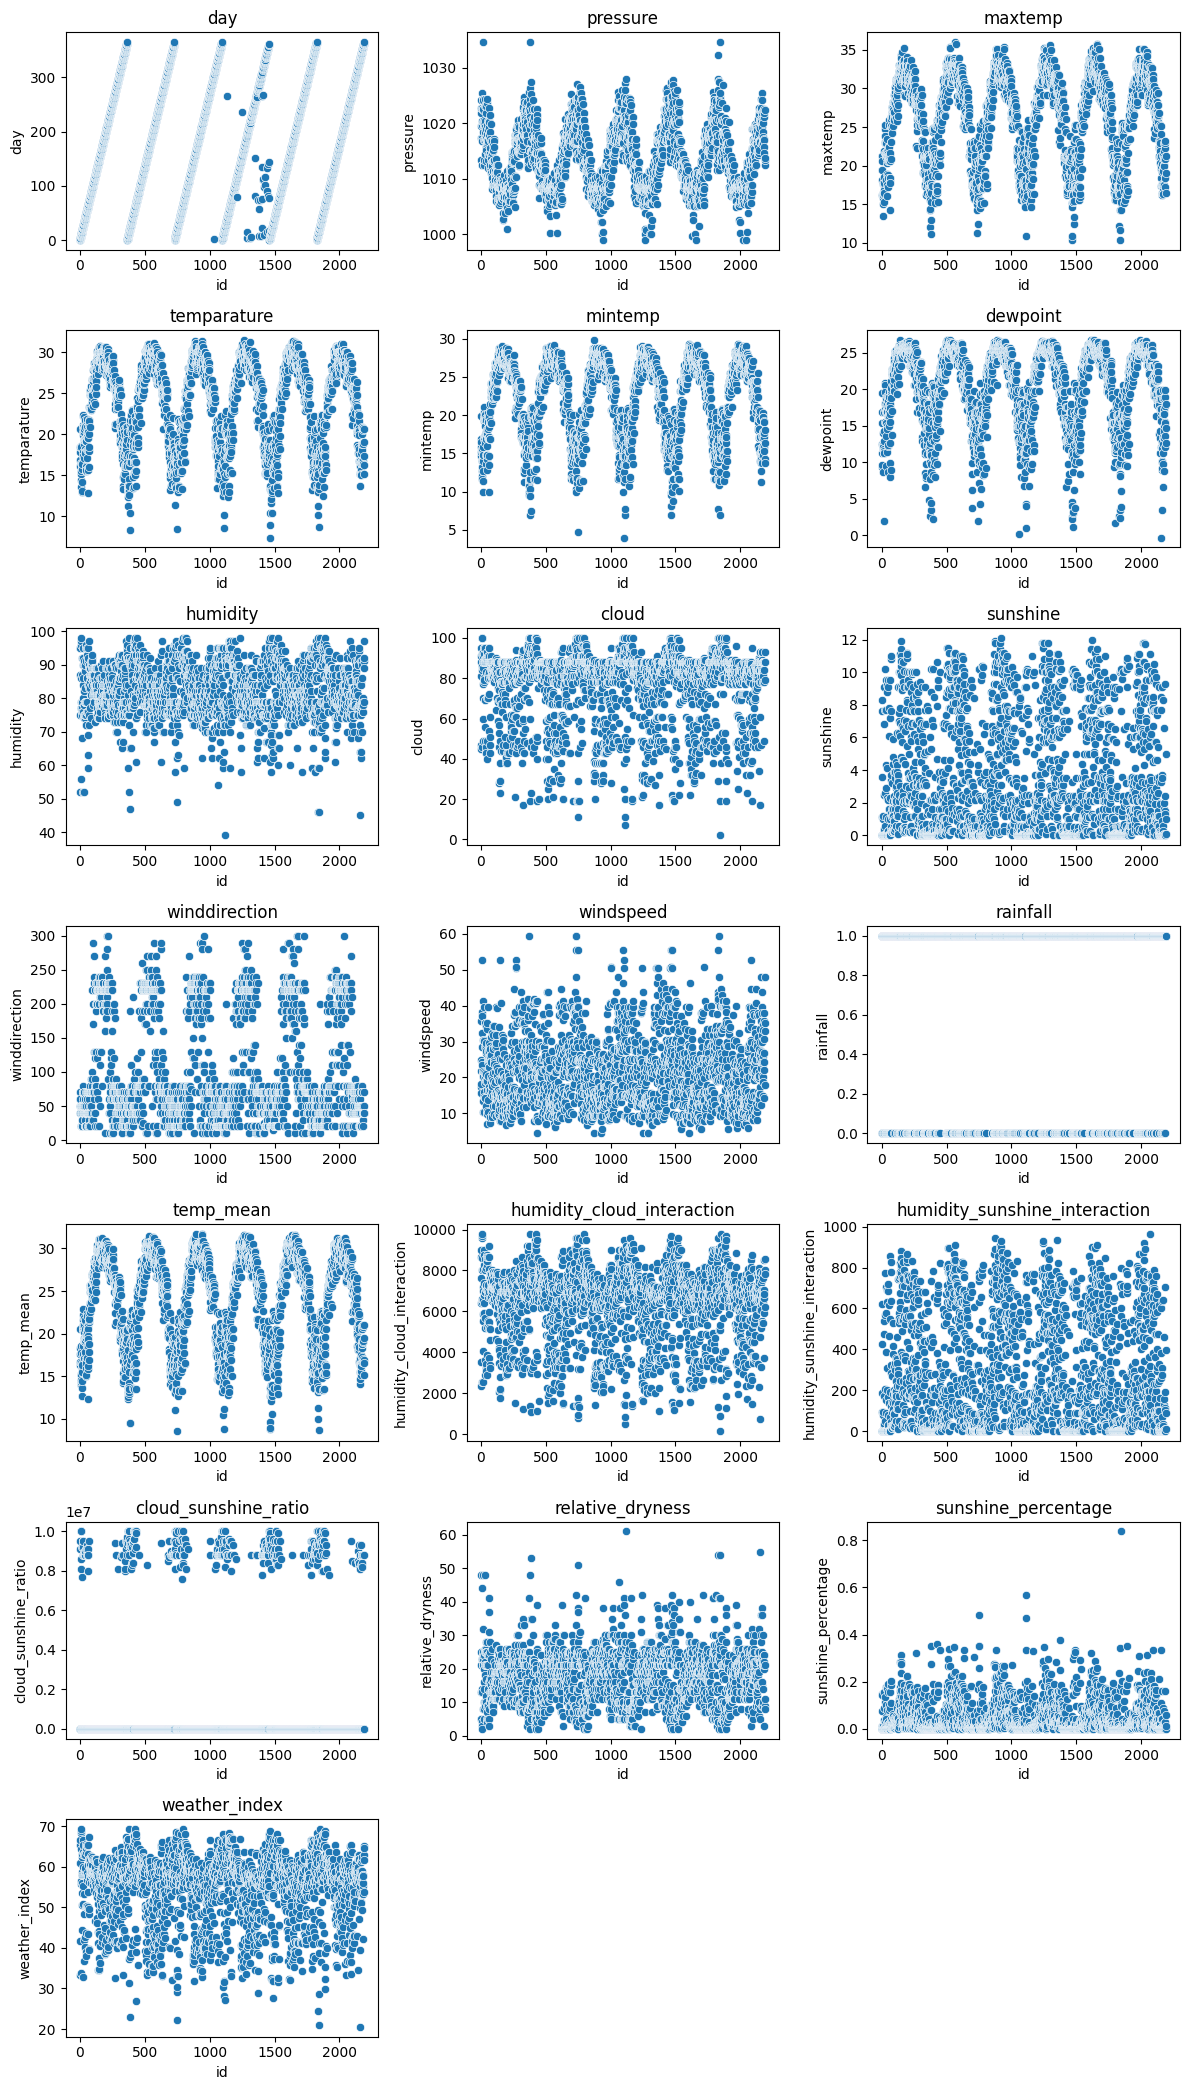

In [661]:
plt.figure(figsize=(12, 21))

for i, col in enumerate(df_train.columns, 1): 
    plt.subplot(7, 3, i)
    sns.scatterplot(x=df_train.index, y=df_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

<Axes: >

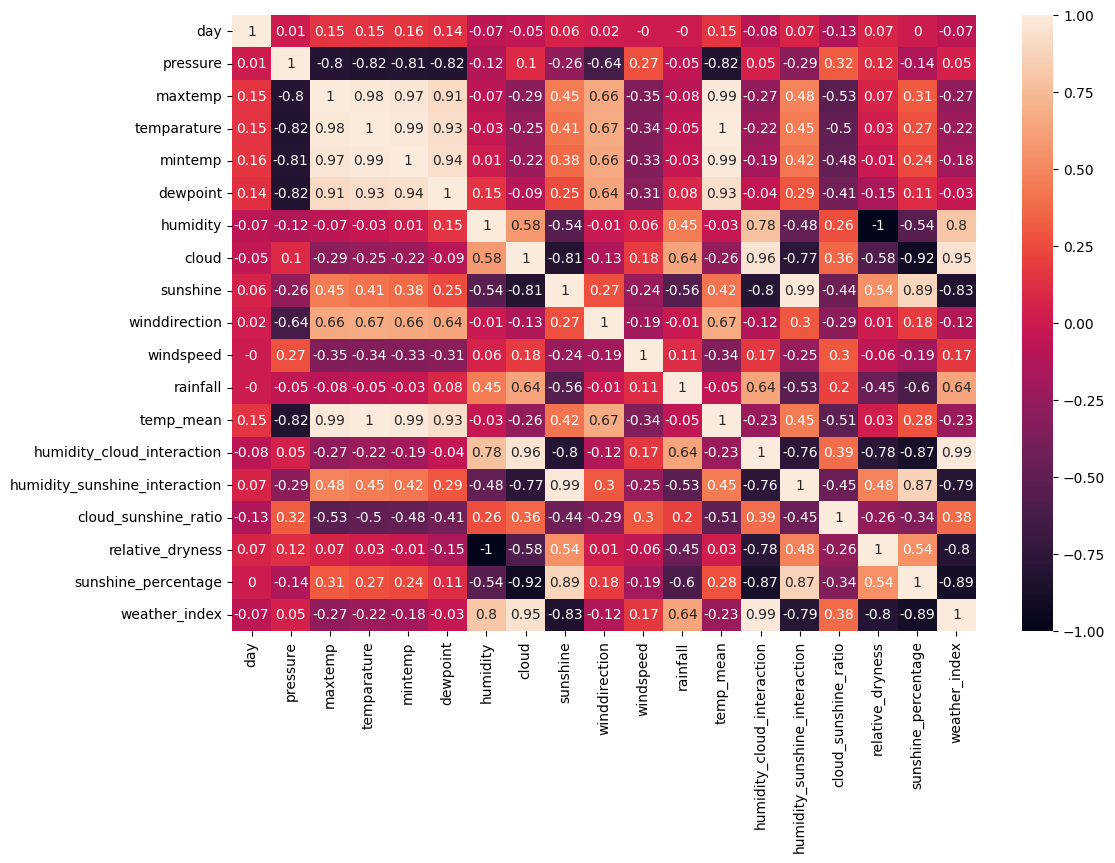

In [662]:
plt.figure(figsize=(12, 8))
corr=df_train.corr().round(2)
sns.heatmap(corr,annot=True)

In [663]:
df_train.columns

Index(['day', 'pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint',
       'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed',
       'rainfall', 'temp_mean', 'humidity_cloud_interaction',
       'humidity_sunshine_interaction', 'cloud_sunshine_ratio',
       'relative_dryness', 'sunshine_percentage', 'weather_index'],
      dtype='object')

In [664]:
X = df_train.drop(columns="rainfall")
y = df_train["rainfall"]

In [665]:
transformer = make_pipeline(
    SimpleImputer(strategy="constant"),
    StandardScaler(),
)

In [666]:
preprocessor = make_column_transformer(
    (transformer, X.columns)
)

In [667]:
# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

In [668]:
input_shape = [X_train.shape[1]]
input_shape

[18]

In [669]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu',input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1,activation='sigmoid')
]
    
)

c:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [670]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"])

Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - binary_accuracy: 0.5970 - loss: 0.8067 - val_binary_accuracy: 0.8011 - val_loss: 0.5657
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - binary_accuracy: 0.8075 - loss: 0.5962 - val_binary_accuracy: 0.8394 - val_loss: 0.5691
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.8160 - loss: 0.5736 - val_binary_accuracy: 0.8193 - val_loss: 0.5868
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.8054 - loss: 0.5394 - val_binary_accuracy: 0.8285 - val_loss: 0.5727
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - binary_accuracy: 0.8305 - loss: 0.4989 - val_binary_accuracy: 0.8431 - val_loss: 0.5494
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - binary_accuracy: 0.8301 - loss: 0.4778 - val_binary_accuracy: 0.8558 - val_loss: 0.5237
Epoch 7/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - binary_accuracy: 0.8448 - loss: 0.4461 - val_binary_accuracy: 0.8686 - val_loss: 0.5107
Epoch 8/200
4/4 ━━━

<Axes: title={'center': 'Accuracy'}>

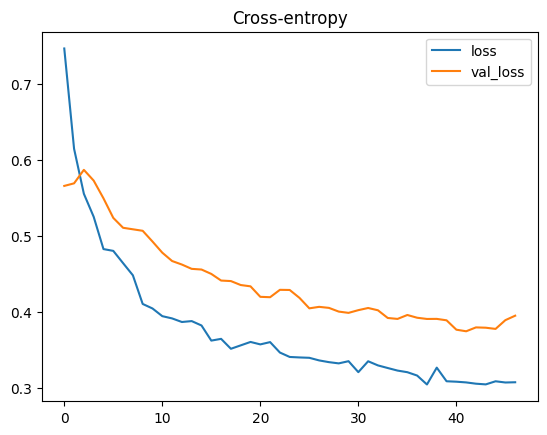

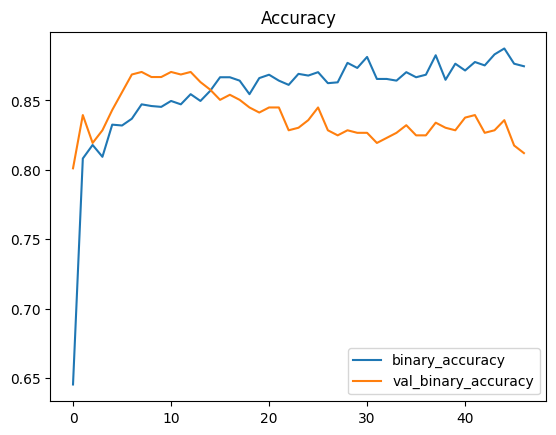

In [671]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [672]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_valid, y_valid))

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - binary_accuracy: 0.8421 - loss: 0.3732 - val_binary_accuracy: 0.8668 - val_loss: 0.3584
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8549 - loss: 0.3848 - val_binary_accuracy: 0.8668 - val_loss: 0.3455
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8703 - loss: 0.3408 - val_binary_accuracy: 0.8540 - val_loss: 0.3522
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8408 - loss: 0.3750 - val_binary_accuracy: 0.8595 - val_loss: 0.3558
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8560 - loss: 0.3590 - val_binary_accuracy: 0.8467 - val_loss: 0.3586
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8701 - loss: 0.3245 - val_binary_accuracy: 0.8595 - val_loss: 0.3686
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.8704 - loss: 0.3269 - val_binary_accuracy: 0.8741 - val_loss: 0.3514
Epoch 8/10
52/52 ━━━

In [673]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Loss: {loss}, Accuracy: {accuracy}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8557 - loss: 0.3928
Loss: 0.35717836022377014, Accuracy: 0.8667883276939392


In [674]:
y_pred=model.predict(X_valid)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [675]:
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix,log_loss

In [676]:
roc_auc_score(y_valid,y_pred)


np.float64(0.8742713657967895)

In [677]:
with open("Binary_pred_rainfall_dataset.pkl","wb") as file:
    pickle.dump((model,preprocessor),file)

In [678]:
df_test=pd.read_csv('test.csv',index_col="id")
df_test["temp_mean"] = df_test[["maxtemp", "temparature", "mintemp"]].mean(axis=1)
df_test['humidity_cloud_interaction'] = df_test['humidity'] * df_test['cloud']
df_test['humidity_sunshine_interaction'] = df_test['humidity'] * df_test['sunshine']
df_test['cloud_sunshine_ratio'] = df_test['cloud'] / (df_test['sunshine'] + 1e-5)
df_test['relative_dryness'] = 100 - df_test['humidity']
df_test['sunshine_percentage'] = df_test['sunshine'] / (df_test['sunshine'] + df_test['cloud'] + 1e-5)
df_test['weather_index'] = (0.4 * df_test['humidity']) + (0.3 * df_test['cloud']) - (0.3 * df_test['sunshine'])
df_test = preprocessor.transform(df_test)

In [679]:
df_test

array([[-1.70193581,  1.0381324 , -1.56201249, ..., -1.76351482,
        -0.81810002,  1.59571585],
       [-1.69247498,  0.5066421 , -1.56201249, ..., -1.88908142,
        -0.81810002,  1.64206354],
       [-1.68301415,  1.81765151, -2.67877978, ..., -0.50784883,
        -0.81810002,  1.02795674],
       ...,
       [ 1.72288562,  1.60505539, -0.94158621, ..., -1.26124843,
        -0.81810002,  1.30604284],
       [ 1.73234645,  0.13459889, -0.94158621, ..., -1.51238162,
        -0.81810002,  1.29445592],
       [ 1.74180729,  1.28616121, -0.72886863, ...,  0.37111736,
        -0.78724873,  0.45324548]])

In [680]:
test_pred=model.predict(df_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [681]:
model_submission=pd.read_csv("sample_submission.csv",index_col="id")
model_submission["rainfall"]=test_pred
model_submission

,rainfall
id,
2190,0.997295
2191,0.998631
2192,0.974017
2193,0.052234
2194,0.013772
...,...
2915,0.994277
2916,0.773368
2917,0.987462


In [682]:
model_submission.to_csv("dl_submission.csv")